In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.colors as mcl
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries

from htc.models.image.DatasetImage import DatasetImage
from htc.settings_seg import settings_seg
from htc.tivita.DataPath import DataPath
from htc.utils.Config import Config
from htc.utils.helper_functions import basic_statistics

In [2]:
df = basic_statistics("2021_02_05_Tivita_multiorgan_semantic", "pigs_semantic-only_5foldsV2.json")
df.head()

,image_name,subject_name,timestamp,label_name,n_pixels,set_type
0,P041#2019_12_14_12_00_16,P041,2019_12_14_12_00_16,bladder,10594,train
1,P041#2019_12_14_12_00_16,P041,2019_12_14_12_00_16,blue_cloth,158624,train
2,P041#2019_12_14_12_00_16,P041,2019_12_14_12_00_16,colon,67779,train
3,P041#2019_12_14_12_00_16,P041,2019_12_14_12_00_16,fat,4251,train
4,P041#2019_12_14_12_00_16,P041,2019_12_14_12_00_16,small_bowel,65634,train


In [3]:
kid_per_df = df.query('label_name == "kidney_with_Gerotas_fascia"')[["subject_name", "timestamp"]]
kid_df = df.query('label_name == "kidney"')[["subject_name", "timestamp"]]
overlap_pigs = []
for pig in kid_per_df["subject_name"].unique():
    if pig in kid_df["subject_name"].unique():
        overlap_pigs.append(pig)

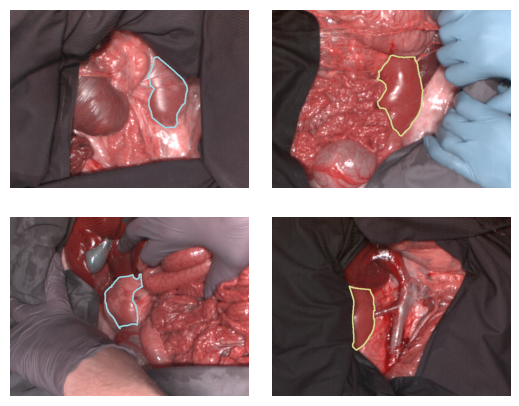

In [4]:
sel_pigs_imgs = [
    "P058#2020_05_13_18_29_50",
    "P062#2020_05_15_19_25_32",
    "P062#2020_05_15_18_58_07",
    "P058#2020_05_13_19_07_49",
]
mapping = settings_seg.label_mapping
config = Config({"input/n_channels": 3, "input/preprocessing": None, "label_mapping": mapping})

fig, axes = plt.subplots(2, 2, figsize=(5, 4), dpi=100)
fig.subplots_adjust(hspace=0.08, wspace=0.1, left=0, right=1, bottom=0, top=1)
for i, image_name in enumerate(sel_pigs_imgs):
    path = DataPath.from_image_name(f"{image_name}")

    dataset = DatasetImage([path], train=False, config=config)
    sample = dataset[0]

    # RGB
    rgb = sample["features"].numpy()
    rgb = (rgb * 255).astype(np.uint8)

    # GT segmentation
    ann = sample["labels"].numpy()
    for label in ["kidney", "kidney_with_Gerotas_fascia"]:
        mask = ann == mapping.name_to_index(label)
        if True in np.unique(mask):
            axes[i // 2, i % 2].imshow(
                mark_boundaries(
                    rgb,
                    mask,
                    color=mcl.to_rgb(settings_seg.label_colors_paper[label]),
                    outline_color=mcl.to_rgb(settings_seg.label_colors_paper[label]),
                    mode="thick",
                )
            )
            axes[i // 2, i % 2].axis("off")

fig.savefig(settings_seg.paper_dir / "kidney_kidney_with_Gerotas_fascia_examples.pdf")